# Install and Import dependencies

In [1]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

     |████████████████████████████████| 412.3 MB 27 kB/s               
     |████████████████████████████████| 240 kB 110.0 MB/s            
     |████████████████████████████████| 2.8 MB 82.1 MB/s            
     |████████████████████████████████| 1.1 MB 83.8 MB/s            
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [2]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


# Bring in Tape Data

In [3]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='project-b-data'
data_key = 'proj-b/Tape_csv/New_Full_Tape.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

c=pd.read_csv(data_location)
c.head()

,Date,Time,Price,Quantity,Party1,Party2
0,2022-01-04,8.192,203,2.0,S26,B24
1,2022-01-04,8.192,199,3.0,S26,B08
2,2022-01-04,10.336,196,3.0,S06,B07
3,2022-01-04,10.672,196,4.0,S01,B01
4,2022-01-04,11.040,201,1.0,S12,B31


In [4]:
#Drop columns that are not needed
df = c.drop(columns=['Party1','Party2'])
df.head()

,Date,Time,Price,Quantity
0,2022-01-04,8.192,203,2.0
1,2022-01-04,8.192,199,3.0
2,2022-01-04,10.336,196,3.0
3,2022-01-04,10.672,196,4.0
4,2022-01-04,11.040,201,1.0


In [5]:
# new data frame with split value columns
new = df["Date"].str.split("-", n = 2, expand = True)
  
# making separate first name column from new data frame
df['Y'] = new[0]
# making separate last name column from new data frame
df['M'] = new[1]
df['D'] = new[2]

df[["Y", "M","D"]] = df[["Y", "M","D"]].apply(pd.to_numeric)

In [6]:
import datetime

#Create datetime column based on  given Time column
from datetime import datetime, timedelta
from datetime import datetime, datetime

dt = []
for i in range(len(df)):
    start = datetime(df['Y'][i], df['M'][i], df['D'][i], 8, 0, 0) #start time when market opens
    dt.append(start + timedelta(seconds = df["Time"][i]))

df['DateTime'] = dt
df.head()

,Date,Time,Price,Quantity,Y,M,D,DateTime
0,2022-01-04,8.192,203,2.0,2022,1,4,2022-01-04 08:00:08.192
1,2022-01-04,8.192,199,3.0,2022,1,4,2022-01-04 08:00:08.192
2,2022-01-04,10.336,196,3.0,2022,1,4,2022-01-04 08:00:10.336
3,2022-01-04,10.672,196,4.0,2022,1,4,2022-01-04 08:00:10.672
4,2022-01-04,11.040,201,1.0,2022,1,4,2022-01-04 08:00:11.040


In [7]:
#High, low, open and close prices for every 5 minutes interval
prices = df.resample('D', on='DateTime').Price.agg(['min','max', 'first','last'])
prices.reset_index(inplace=True)
prices

,DateTime,min,max,first,last
0,2022-01-04,179.0,238.0,203.0,219.0
1,2022-01-05,196.0,242.0,219.0,212.0
2,2022-01-06,186.0,242.0,242.0,190.0
3,2022-01-07,185.0,237.0,187.0,206.0
4,2022-01-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...
111,2022-04-25,109.0,145.0,120.0,140.0
112,2022-04-26,110.0,147.0,110.0,146.0
113,2022-04-27,111.0,147.0,147.0,140.0
114,2022-04-28,105.0,141.0,125.0,133.0


In [8]:
df_Q = df.drop(columns=['Date', 'Time', 'Price', 'Y', 'M', 'D'])
df_Q.head()

,Quantity,DateTime
0,2.0,2022-01-04 08:00:08.192
1,3.0,2022-01-04 08:00:08.192
2,3.0,2022-01-04 08:00:10.336
3,4.0,2022-01-04 08:00:10.672
4,1.0,2022-01-04 08:00:11.040


In [9]:
df_Q[["Quantity"]] = df[["Quantity"]].apply(pd.to_numeric)

qty = df_Q.resample('D', on='DateTime').sum()
qty.head()

,Quantity
DateTime,
2022-01-04,118075.0
2022-01-05,117591.0
2022-01-06,118054.0
2022-01-07,118730.0
2022-01-08,0.0


In [10]:
Quantity = qty['Quantity'].tolist()

prices['Quantity'] = Quantity
prices.dropna(subset=['min'], inplace=True)
prices.head()

,DateTime,min,max,first,last,Quantity
0,2022-01-04,179.0,238.0,203.0,219.0,118075.0
1,2022-01-05,196.0,242.0,219.0,212.0,117591.0
2,2022-01-06,186.0,242.0,242.0,190.0,118054.0
3,2022-01-07,185.0,237.0,187.0,206.0,118730.0
6,2022-01-10,184.0,233.0,202.0,211.0,118508.0


In [11]:
prices.rename(columns = {'DateTime':'Date', 'min':'Low', 'max':'High', 'first':'Open', 'last':'Close', 'Quantity':'Volume'}, inplace = True)
prices.set_index('Date', inplace=True)
prices.head()

,Low,High,Open,Close,Volume
Date,,,,,
2022-01-04,179.0,238.0,203.0,219.0,118075.0
2022-01-05,196.0,242.0,219.0,212.0,117591.0
2022-01-06,186.0,242.0,242.0,190.0,118054.0
2022-01-07,185.0,237.0,187.0,206.0,118730.0
2022-01-10,184.0,233.0,202.0,211.0,118508.0


# Build environment

In [12]:
env = gym.make('stocks-v0', df=prices, frame_bound=(5,60), window_size=5)
env.signal_features

array([[219.,   0.],
       [212.,  -7.],
       [190., -22.],
       [206.,  16.],
       [211.,   5.],
       [195., -16.],
       [192.,  -3.],
       [188.,  -4.],
       [227.,  39.],
       [205., -22.],
       [183., -22.],
       [197.,  14.],
       [218.,  21.],
       [237.,  19.],
       [237.,   0.],
       [158., -79.],
       [184.,  26.],
       [213.,  29.],
       [202., -11.],
       [203.,   1.],
       [184., -19.],
       [174., -10.],
       [200.,  26.],
       [190., -10.],
       [215.,  25.],
       [281.,  66.],
       [278.,  -3.],
       [240., -38.],
       [250.,  10.],
       [231., -19.],
       [258.,  27.],
       [265.,   7.],
       [221., -44.],
       [217.,  -4.],
       [231.,  14.],
       [186., -45.],
       [195.,   9.],
       [245.,  50.],
       [227., -18.],
       [158., -69.],
       [181.,  23.],
       [196.,  15.],
       [206.,  10.],
       [182., -24.],
       [158., -24.],
       [183.,  25.],
       [202.,  19.],
       [207.,

info {'total_reward': 152.0, 'total_profit': 1.8890740190999915, 'position': 0}


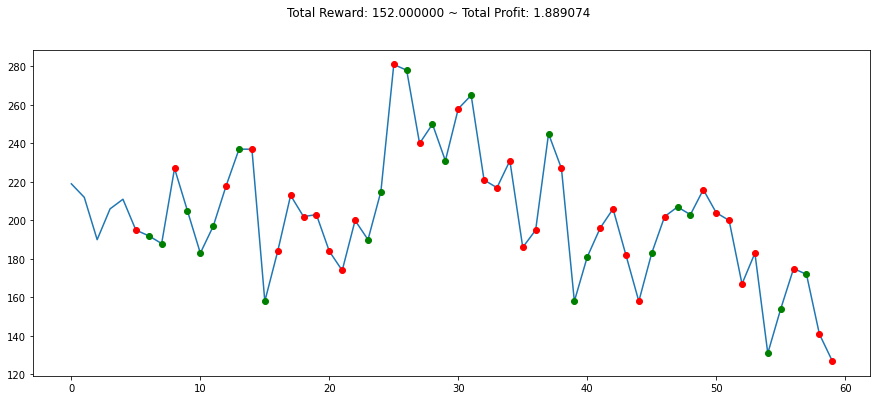

In [13]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Build Environment & Train

In [14]:
env_maker = lambda: gym.make('stocks-v0', df=prices, frame_bound=(5,60), window_size=5)
env = DummyVecEnv([env_maker])

In [15]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.000937 |
| fps                | 16       |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 450      |
---------------------------------
---------------------------------
| explained_variance | 0.000424 |
| fps                | 408      |
| nupdates           | 100      |
| policy_entropy     | 0.692    |
| total_timesteps    | 500      |
| value_loss         | 267      |
---------------------------------
----------------------------------
| explained_variance | -8.25e-05 |
| fps                | 468   

# Evaluation

In [16]:
env = gym.make('stocks-v0', df=prices, frame_bound=(50,81), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 0.65505825, 'position': 1}


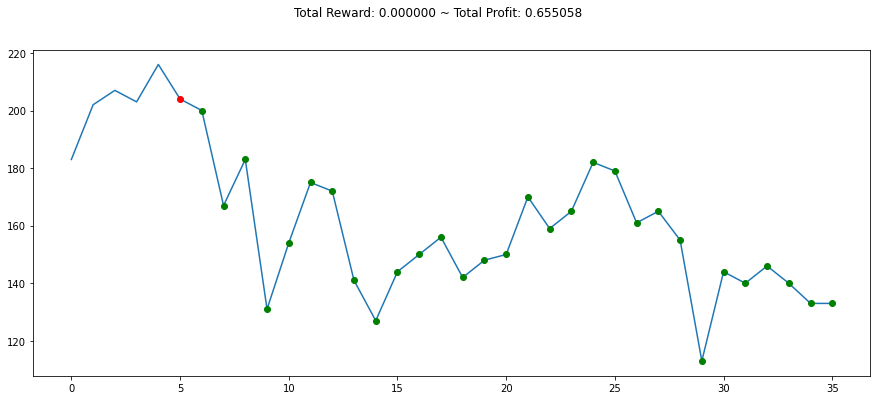

In [17]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

-------------------------------------------------------------------------------------

# With trading custom indicators 

# Install and Import New Dependencies

In [18]:
!pip install finta

In [19]:
from gym_anytrading.envs import StocksEnv
from finta import TA

# Calculate SMA, RSI and OBV

In [23]:
prices['SMA'] = TA.SMA(prices, 12)
prices['RSI'] = TA.RSI(prices)
prices['OBV'] = TA.OBV(prices)
prices.fillna(0, inplace=True)

In [24]:
prices.head(15)

,Low,High,Open,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2022-01-04,179.0,238.0,203.0,219.0,118075.0,0.000000,0.000000,0.0
2022-01-05,196.0,242.0,219.0,212.0,117591.0,0.000000,0.000000,-117591.0
2022-01-06,186.0,242.0,242.0,190.0,118054.0,0.000000,0.000000,-235645.0
2022-01-07,185.0,237.0,187.0,206.0,118730.0,0.000000,37.678722,-116915.0
2022-01-10,184.0,233.0,202.0,211.0,118508.0,0.000000,44.691968,1593.0
2022-01-11,165.0,216.0,199.0,195.0,118355.0,0.000000,32.203266,-116762.0
2022-01-12,162.0,201.0,184.0,192.0,119060.0,0.000000,30.483240,-235822.0
2022-01-13,160.0,219.0,185.0,188.0,118310.0,0.000000,28.311902,-354132.0
2022-01-14,182.0,229.0,187.0,227.0,118330.0,0.000000,58.986645,-235802.0


# Create New Environments

In [44]:
df = prices
df

,Low,High,Open,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2022-01-04,179.0,238.0,203.0,219.0,118075.0,0.000000,0.000000,0.0
2022-01-05,196.0,242.0,219.0,212.0,117591.0,0.000000,0.000000,-117591.0
2022-01-06,186.0,242.0,242.0,190.0,118054.0,0.000000,0.000000,-235645.0
2022-01-07,185.0,237.0,187.0,206.0,118730.0,0.000000,37.678722,-116915.0
2022-01-10,184.0,233.0,202.0,211.0,118508.0,0.000000,44.691968,1593.0
...,...,...,...,...,...,...,...,...
2022-04-25,109.0,145.0,120.0,140.0,118778.0,156.916667,44.792890,121565.0
2022-04-26,110.0,147.0,110.0,146.0,118181.0,156.583333,46.351111,239746.0
2022-04-27,111.0,147.0,147.0,140.0,118796.0,154.083333,44.983777,120950.0


In [45]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    price = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return price, signal_features

In [46]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [47]:
env2.signal_features

array([[ 1.79000000e+02,  1.18075000e+05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.96000000e+02,  1.17591000e+05,  0.00000000e+00,
         0.00000000e+00, -1.17591000e+05],
       [ 1.86000000e+02,  1.18054000e+05,  0.00000000e+00,
         0.00000000e+00, -2.35645000e+05],
       [ 1.85000000e+02,  1.18730000e+05,  0.00000000e+00,
         3.76787216e+01, -1.16915000e+05],
       [ 1.84000000e+02,  1.18508000e+05,  0.00000000e+00,
         4.46919676e+01,  1.59300000e+03],
       [ 1.65000000e+02,  1.18355000e+05,  0.00000000e+00,
         3.22032658e+01, -1.16762000e+05],
       [ 1.62000000e+02,  1.19060000e+05,  0.00000000e+00,
         3.04832402e+01, -2.35822000e+05],
       [ 1.60000000e+02,  1.18310000e+05,  0.00000000e+00,
         2.83119021e+01, -3.54132000e+05],
       [ 1.82000000e+02,  1.18330000e+05,  0.00000000e+00,
         5.89866447e+01, -2.35802000e+05],
       [ 1.82000000e+02,  1.18860000e+05,  0.00000000e+00,
         4.68169487e+01

In [48]:
df.head()

,Low,High,Open,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2022-01-04,179.0,238.0,203.0,219.0,118075.0,0.0,0.000000,0.0
2022-01-05,196.0,242.0,219.0,212.0,117591.0,0.0,0.000000,-117591.0
2022-01-06,186.0,242.0,242.0,190.0,118054.0,0.0,0.000000,-235645.0
2022-01-07,185.0,237.0,187.0,206.0,118730.0,0.0,37.678722,-116915.0
2022-01-10,184.0,233.0,202.0,211.0,118508.0,0.0,44.691968,1593.0


# Build Environment and Train

In [49]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [50]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

---------------------------------
| explained_variance | -0.00194 |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 569      |
---------------------------------
---------------------------------
| explained_variance | -262     |
| fps                | 477      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 0.00284  |
---------------------------------
---------------------------------
| explained_variance | 0.000771 |
| fps                | 549      |
| nupdates           | 200      |
| policy_entropy     | 0.693    |
| total_timesteps    | 1000     |
| value_loss         | 211      |
---------------------------------
----------------------------------
| explained_variance | -0.000316 |
| fps                | 578       |
| nupdates           | 300       |
| policy_entropy     | 0.693     |
| total_t

# Evaluation

In [54]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(30,80))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -65.0, 'total_profit': 0.5596680788247191, 'position': 0}


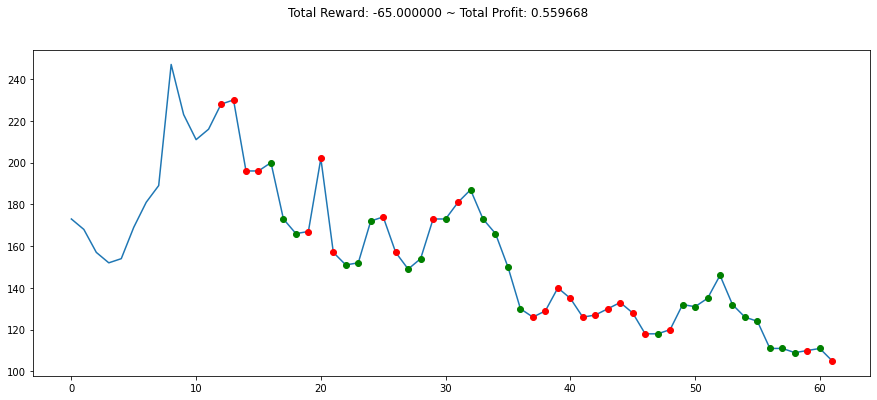

In [55]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()